In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import scipy.linalg

import pyequion2
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [23]:
class TransportBuilder(object):
    def __init__(self, eqsys, TK, shear_velocity, kinematic_viscosity, cbulk, phases):
        self.eqsys = eqsys
        self.TK = TK
        self.shear_velocity = shear_velocity
        self.kinematic_viscosity = kinematic_viscosity
        self.cbulk = cbulk
        self.phases = phases
        
    def set_species(self, species_to_remove=[]):
        self.basedict = {k: v
                         for k, v in pyequion2.datamods.chemical_potentials.items()
                         if k in self.eqsys.solutes
                         and k not in species_to_remove}
        self.species = [spec for spec in eqsys.species[1:] if spec not in species_to_remove]
        self.species_ind = jnp.array([eqsys.species.index(spec) for spec in self.species])
        self.solid_ind = jnp.array([eqsys.solid_phase_names.index(phase) for phase in self.phases])
        self.reduced_formula_matrix = self.eqsys.formula_matrix[2:, self.species_ind]
        self.reduced_reaction_vector = \
            eqsys.solid_stoich_matrix[self.solid_ind, :][:, self.species_ind]
        self.closure_matrix = jnp.array(
            scipy.linalg.null_space(
                (self.reduced_formula_matrix@(self.reduced_reaction_vector.T)).T
            ).T
        )
        self.nspecies = len(self.species)
        self.logk_solid = eqsys.get_solid_log_equilibrium_constants(self.TK)[self.solid_ind]
        self.reduced_standard_potentials = eqsys.get_standard_chemical_potentials(self.TK)[self.species_ind]
        self.reduced_standard_potentials /= (pyequion2.constants.GAS_CONSTANT*self.TK)    
        self.reduce_activity_function()
        self.reduced_diffusion_coefficients = pyequion2.equilibrium_backend.diffusion_coefficients.get_diffusion_coefficients(
                                        self.species, self.TK)
        self.reduced_diffusion_coefficients = jnp.array(self.reduced_diffusion_coefficients)/self.kinematic_viscosity
        
    def reduce_activity_function(self):
        self._actfunc = pyequion2.equilibrium_backend.ACTIVITY_MODEL_MAP[eqsys.activity_model](
                            self.species, backend="jax")
        
    def activity_model_func(self, molals, TK):
        return self._actfunc(molals, TK)[..., 1:]/pyequion2.constants.LOG10E
        
    def make_grid(self, ngrid, ymax):
        self.ngrid = ngrid
        self.npoints = ngrid + 1
        self.ymax = ymax
        self.ygrid, self.ystep = jnp.linspace(0, self.ymax, self.npoints, retstep=True)
        
    def wall_diffusion_plus(self, yplus):
        return 9.5*1e-4*yplus**3
    
    def wall_diffusion_plus_deriv(self, yplus):
        return 3*9.5*1e-4*yplus**2
    
    def bulk_boundary_condition(self, logc):
        c = jnp.exp(logc)
        cbulk = self.cbulk[..., None]
        return self.reduced_formula_matrix@(c[:, -1][..., None]) - cbulk
        
    def equilibrium_wall_boundary_condition(self, logc):
        c = jnp.exp(logc)
        mu = self.chemical_potentials(logc)
        cm = c[:, 0]
        dc = (c[:, 1] - c[:, 0])/(self.ystep)
        dmu = (mu[:, 1] - mu[:, 0])/self.ystep
        loga = jnp.log(c[:,0]) + self.activity_model_func(c[:,0], self.TK)
        res1 = self.reduced_reaction_vector@loga - self.logk_solid[..., None]
        res2 = self.closure_matrix@self.reduced_formula_matrix@\
                  (self.reduced_diffusion_coefficients*cm*dmu)[..., None]
        res = jnp.vstack([res1, res2])
        return res

    def transport_residual(self, logc):
        #logc : (nsolutes, ngrid)
        #mu : (nsolutes, ngrid)
        c = jnp.exp(logc)
        mu = self.chemical_potentials(logc)
        ymiddle = self.ygrid[1:-1]
        cm = c[:, 1:-1]
        d1c = (c[:, 2:] - c[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d1mu = (mu[:, 2:] - mu[:, :-2])/(2*self.ystep) #(nsolutes, ngrid-2)
        d2c = (c[:, 2:] - 2*c[:, 1:-1] + c[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2
        d2mu = (mu[:, 2:] - 2*mu[:, 1:-1] + mu[:, :-2])/(self.ystep**2) #(nsolutes, ngrid-2)        
        molecular_diffusions = self.reduced_diffusion_coefficients[..., None] #(nsolutes, 1)
        turbulent_diffusions = self.wall_diffusion_plus(ymiddle)
        turbulent_diffusions_deriv = self.wall_diffusion_plus_deriv(ymiddle)
        term1 = molecular_diffusions*(d1c*d1mu + cm*d2mu)
        term2 = turbulent_diffusions*d2c + turbulent_diffusions_deriv*d1c
        term = term1 + term2
        res = self.reduced_formula_matrix@term
        return res
                
    def chemical_potentials(self, logc):
        logg = self.activity_model_func(jnp.exp(logc).T, self.TK).T
        mu0 = self.reduced_standard_potentials[..., None]
        return mu0 + logg + logc
    
    def full_residual(self, log):
        res1a = self.equilibrium_wall_boundary_condition(logc)
        res1b = self.transport_residual(logc)
        res1c = self.bulk_boundary_condition(logc)
        res1 = jnp.hstack([res1a, res1b, res1c])
        res = res1
        return res
    
    def bulk_residual(self, logc):
        res1 = self.bulk_boundary_condition(logc)
        res3 = self.potential_residual(logc)
        res = jnp.vstack([res1, res3])
        return res

    def gibbs_free_energy(self, logc):
        c = jnp.exp(logc)
        mu = self.chemical_potentials(logc)
        return jnp.mean(jnp.sum(c*mu, axis=0))    
    
    def flattened_equality_constraint(self, x):
        cmu = x.reshape(self.nspecies, self.npoints)
        return self.full_residual(cmu).flatten()
    
    def flattened_minimization_objective(self, x):
        cmu = x.reshape(self.nspecies, self.npoints)
        return self.gibbs_free_energy(cmu).flatten()[0]
        
    def wall_length(self):
        return self.kinematic_viscosity/self.shear_velocity
    
    def wall_time(self):
        return self.kinematic_viscosity/(self.shear_velocity**2)
    
    def get_log_equilibrium_constants(self, TK):
        return self.eqsys.get_log_equilibrium_constants(TK)

In [24]:
eqsys = pyequion2.EquilibriumBackend(["Na", "Cl", "Ca", "C"], from_elements=True, backend="jax", logbase="e")

In [25]:
builder = TransportBuilder(eqsys, 298.15, 0.1, 1e-6, jnp.array([1e-1, 1e-1, 1e-1, 1e-1, 0.0]), ["Calcite"])
builder.set_species(['CaCO3', 'CaHCO3+', 'CCaOH+', 'Na2CO3', 'NaCO3-', 'NaHCO3', 'NaOH', 'CaOH+',
                     'H+', 'OH-'])
builder.make_grid(20, 5)
builder.species

['CO2', 'CO3--', 'Ca++', 'Cl-', 'HCO3-', 'Na+']

In [26]:
logc = np.ones([builder.nspecies, builder.npoints])*0.0 - 3.0

In [27]:
builder.gibbs_free_energy(logc)

DeviceArray(-1.1157452, dtype=float32)

In [28]:
constraints = {'type':'eq',
               'fun':jax.jit(builder.flattened_equality_constraint),
               'jac':jax.jit(jax.jacfwd(builder.flattened_equality_constraint))}
equality_constraint = scipy.optimize.NonlinearConstraint(
    jax.jit(builder.flattened_equality_constraint),
    lb=0.0,
    ub=0.0,
    jac = jax.jit(jax.jacfwd(builder.flattened_equality_constraint)))


In [30]:
sol = scipy.optimize.minimize(jax.jit(builder.flattened_minimization_objective),
                              logc.flatten(),
                              jac = jax.jit(jax.grad(builder.flattened_minimization_objective)),
                              constraints=equality_constraint,
                              method='trust-constr')

/home/dfnaiff/miniconda3/envs/mainenv/lib/python3.9/site-packages/scipy/optimize/_trustregion_constr/projections.py:181: UserWarning: Singular Jacobian matrix. Using SVD decomposition to perform the factorizations.
  warn('Singular Jacobian matrix. Using SVD decomposition to ' +


In [31]:
sol.success

False

In [34]:
logc = sol.x.reshape(builder.nspecies, builder.npoints)
c = np.exp(logc)

Text(0.5, 0, '$y^+$')

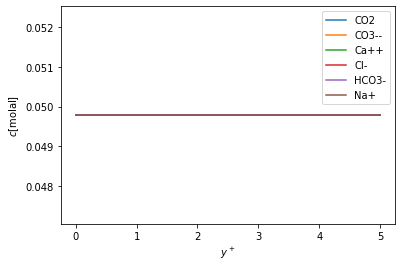

In [35]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')

Text(0.5, 0, '$y^+$')

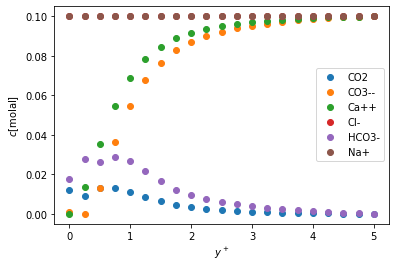

In [33]:
plt.figure()
for i in range(builder.nspecies):
    plt.plot(builder.ygrid, c[i, :], 'o', label=builder.species[i])
plt.legend()
plt.ylabel(r'$c$[molal]')
plt.xlabel(r'$y^+$')